In [14]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [15]:
import pandas as pd

# Load the uploaded dataset
file_path = "/content/fashion_sustainability_cleaned_final.csv"
df_uploaded = pd.read_csv(file_path)

# Selecting relevant columns for ARM transaction-style format
transaction_data = df_uploaded[["Brand_Name", "Material_Type", "Eco_Friendly_Manufacturing",
                                "Recycling_Programs", "Certifications"]]

# Convert each row into a transaction-like format
transaction_data["Transaction_Items"] = transaction_data.apply(lambda row:
    f"{row['Material_Type']}, {row['Eco_Friendly_Manufacturing']}, {row['Recycling_Programs']}, {row['Certifications']}", axis=1)

# Select only necessary columns for ARM
transaction_data = transaction_data[["Brand_Name", "Transaction_Items"]]



<ipython-input-15-c16dcc8ab139>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_data["Transaction_Items"] = transaction_data.apply(lambda row:


In [16]:
transaction_data.head()

,Brand_Name,Transaction_Items
0,Brand_1127,"Hemp, Yes, Yes, Fair Trade"
1,Brand_80,"Vegan Leather, No, No, B Corp"
2,Brand_3261,"Bamboo Fabric, Yes, Yes, B Corp"
3,Brand_1737,"Recycled Polyester, Yes, Yes, GOTS"
4,Brand_4527,"Organic Cotton, Yes, Yes, B Corp"


In [46]:
transaction_data.to_csv("/content/arm_transactions.csv", index=False)

In [17]:
# Prepare transactions by grouping items as lists per brand
transaction_data_grouped = transaction_data.groupby("Brand_Name").agg(lambda x: list(x)).reset_index()


In [18]:
transaction_data_grouped.head()

,Brand_Name,Transaction_Items
0,Brand_1,"[Tencel, No, No, GOTS]"
1,Brand_10,"[Bamboo Fabric, No, No, B Corp]"
2,Brand_100,"[Recycled Polyester, No, No, Fair Trade]"
3,Brand_1000,"[Recycled Polyester, No, No, GOTS]"
4,Brand_1001,"[Organic Cotton, No, No, B Corp]"


In [19]:
# Convert transactions into a list of lists
transactions = transaction_data_grouped.drop(columns=["Brand_Name"]).values.tolist()
transactions = [[item for sublist in transaction for item in sublist] for transaction in transactions]


In [20]:
from mlxtend.frequent_patterns import apriori, association_rules

In [21]:
print(transactions[:5])

[['Tencel, No, No, GOTS'], ['Bamboo Fabric, No, No, B Corp'], ['Recycled Polyester, No, No, Fair Trade'], ['Recycled Polyester, No, No, GOTS'], ['Organic Cotton, No, No, B Corp']]


In [26]:


# Flatten transactions
transactions = transaction_data_grouped["Transaction_Items"].apply(lambda x: [item for sublist in x for item in sublist]).tolist()

# Encode transactions into one-hot format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm with a lower support threshold
min_support_threshold = 0.01  # Adjusted to capture more frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=min_support_threshold, use_colnames=True)

if frequent_itemsets.empty:
    print("No frequent itemsets found. Consider lowering the min_support threshold further.")
else:
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    # Extract key components: Support, Confidence, Lift
    key_metrics = rules.copy()
    key_metrics["antecedents"] = key_metrics["antecedents"].apply(lambda x: ', '.join(list(x)))
    key_metrics["consequents"] = key_metrics["consequents"].apply(lambda x: ', '.join(list(x)))
    key_metrics = key_metrics[["antecedents", "consequents", "support", "confidence", "lift"]]



<ipython-input-26-50bb963823d5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_data["Transaction_Items"] = transaction_data.apply(lambda row:


In [27]:

# Save rules to a CSV file
rules_output_file = "/content/arm_rules.csv"  # Specify a path within the Colab environment
key_metrics.to_csv(rules_output_file, index=False)
print(f"Key association rule metrics saved to: {rules_output_file}")


Key association rule metrics saved to: /content/arm_rules.csv


In [29]:
rules_file = "/content/arm_rules.csv"
rules = pd.read_csv(rules_file)
rules.head()

,antecedents,consequents,support,confidence,lift
0,B Corp,Bamboo Fabric,0.039497,0.165829,1.011316
1,Bamboo Fabric,B Corp,0.039497,0.240876,1.011316
2,Hemp,B Corp,0.041093,0.242925,1.019917
3,B Corp,Hemp,0.041093,0.172529,1.019917
4,B Corp,No,0.179733,0.754606,1.011996


In [30]:
top_support = rules.nlargest(15, 'support')
top_confidence = rules.nlargest(15, 'confidence')
top_lift = rules.nlargest(15, 'lift')

In [48]:
def plot_metric_distribution(rules_df, metric, title):
    plt.figure(figsize=(12, 6))
    sns.histplot(rules_df[metric], bins=20, kde=True, color="blue")
    plt.xlabel(metric.capitalize())
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {title}")
    plt.show()

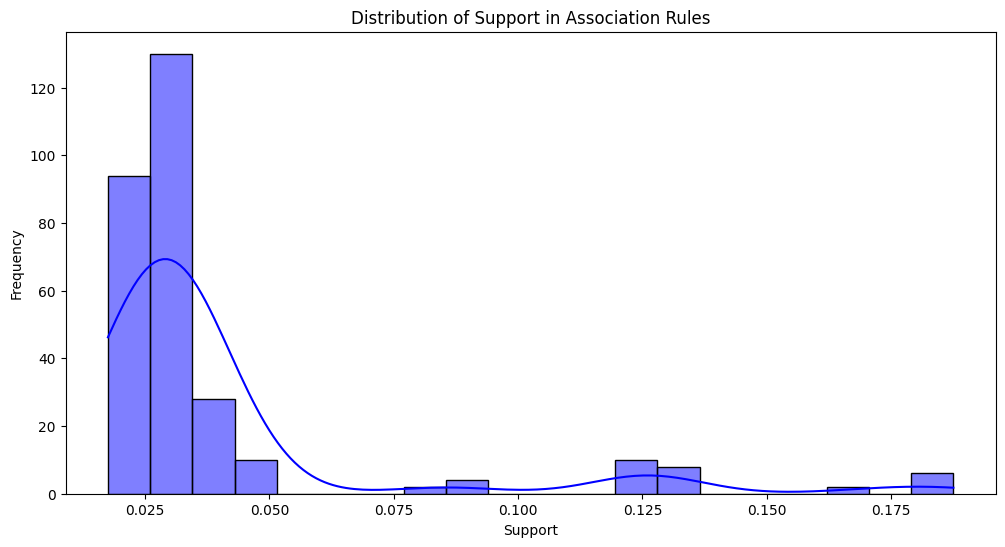

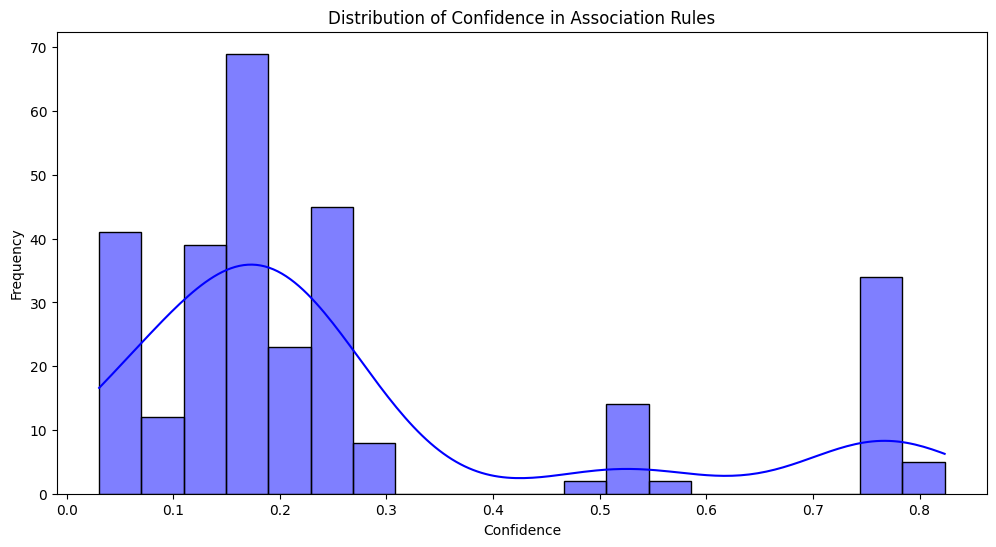

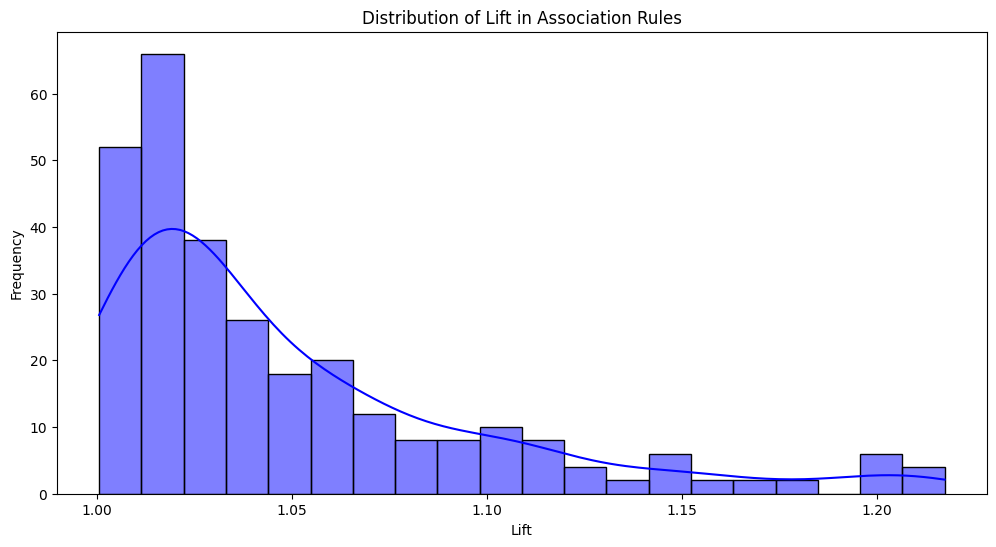

In [49]:
# Plot histograms for Support, Confidence, and Lift
plot_metric_distribution(rules, "support", "Support in Association Rules")
plot_metric_distribution(rules, "confidence", "Confidence in Association Rules")
plot_metric_distribution(rules, "lift", "Lift in Association Rules")

In [34]:

print("Top 15 Rules by Support:")
print(top_support)



Top 15 Rules by Support:
           antecedents         consequents   support  confidence      lift
46            OEKO-TEX                 Yes  0.187512    0.766096  1.014379
47                 Yes            OEKO-TEX  0.187512    0.248283  1.014379
10              B Corp                 Yes  0.181728    0.762982  1.010255
11                 Yes              B Corp  0.181728    0.240623  1.010255
4               B Corp                  No  0.179733    0.754606  1.011996
5                   No              B Corp  0.179733    0.241038  1.011996
20                  No          Fair Trade  0.168562    0.226057  1.005521
21          Fair Trade                  No  0.168562    0.749778  1.005521
36  Recycled Polyester                  No  0.129862    0.747417  1.002354
37                  No  Recycled Polyester  0.129862    0.174157  1.002354
14       Bamboo Fabric                 Yes  0.129064    0.787105  1.042196
15                 Yes       Bamboo Fabric  0.129064    0.170893  1.042196


In [32]:
print("\nTop 15 Rules by Confidence:")
print(top_confidence)


Top 15 Rules by Confidence:
                    antecedents consequents   support  confidence      lift
115     Bamboo Fabric, OEKO-TEX         Yes  0.036306    0.823529  1.090426
121            Hemp, Fair Trade          No  0.034710    0.820755  1.100707
144   Fair Trade, Vegan Leather         Yes  0.029723    0.801075  1.060695
149                  Hemp, GOTS         Yes  0.032715    0.800000  1.059271
14                Bamboo Fabric         Yes  0.129064    0.787105  1.042196
104         Bamboo Fabric, GOTS         Yes  0.032316    0.778846  1.031261
79       B Corp, Organic Cotton         Yes  0.033513    0.777778  1.029847
72               B Corp, Tencel          No  0.028526    0.777174  1.042261
90               B Corp, Tencel         Yes  0.028526    0.777174  1.029047
136  Organic Cotton, Fair Trade         Yes  0.025534    0.775758  1.027172
74        B Corp, Vegan Leather          No  0.027927    0.773481  1.037308
51        B Corp, Bamboo Fabric         Yes  0.030521    0.

In [33]:
print("\nTop 15 Rules by Lift:")
print(top_lift)


Top 15 Rules by Lift:
                 antecedents              consequents   support  confidence  \
122           No, Fair Trade                     Hemp  0.034710    0.205917   
123                     Hemp           No, Fair Trade  0.034710    0.205189   
207  Yes, Organic Cotton, No                   B Corp  0.023140    0.287841   
214                   B Corp  Yes, Organic Cotton, No  0.023140    0.097152   
252      Yes, No, Fair Trade                     Hemp  0.022741    0.203936   
259                     Hemp      Yes, No, Fair Trade  0.022741    0.134434   
240        OEKO-TEX, Yes, No            Bamboo Fabric  0.024536    0.197115   
247            Bamboo Fabric        OEKO-TEX, Yes, No  0.024536    0.149635   
120                 Hemp, No               Fair Trade  0.034710    0.269767   
125               Fair Trade                 Hemp, No  0.034710    0.154392   
116            OEKO-TEX, Yes            Bamboo Fabric  0.036306    0.193617   
117            Bamboo Fabric 

### **Insights from the Top 15 Rules by Support**
- **OEKO-TEX, B Corp, and Fair Trade certifications** appear frequently with high support, meaning they are widely adopted across multiple brands.  
- The presence of **Recycled Polyester and Bamboo Fabric** in high-support rules suggests that **many brands incorporate sustainable materials in their supply chain**.  
- The **"Yes" and "No" attributes** indicate a divide in sustainability adoption, where some brands strongly commit while others do not.  

---

### **Insights from the Top 15 Rules by Confidence**
- **Bamboo Fabric, OEKO-TEX, and Fair Trade certifications** have **high confidence values (~0.8)**, meaning that **when these attributes appear, they strongly predict sustainable practices**.  
- **Hemp and Vegan Leather also appear in high-confidence rules**, reinforcing that **specific eco-friendly materials are strong indicators of a brand’s sustainability efforts**.  
- The **B Corp certification’s confidence values (~0.77)** show that **many brands with this certification also adopt other sustainability measures, but not always consistently**.  

---

### **Insights from the Top 15 Rules by Lift**
- **The highest lift values (~1.2) suggest weak but meaningful associations**, meaning that while sustainable practices **tend to co-occur, they are not strictly dependent on each other**.  
- **"No, Fair Trade" and "Hemp" have the highest lift (1.217)**, implying that **brands that do not follow Fair Trade principles are still likely to use hemp, showing selective sustainability practices**.  
- **Bamboo Fabric and OEKO-TEX appear frequently in high-lift rules**, reinforcing that **brands using plant-based textiles tend to ensure they meet chemical safety standards**.  

These insights suggest that while **many brands adopt sustainability certifications and materials, their commitments vary**, leading to **partial or selective adoption of sustainability measures** in the fashion industry. 🚀

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

In [38]:
# Visualization - Network Graph of Association Rules
def draw_network_graph(rules_df, title):
    G = nx.DiGraph()

    for _, row in rules_df.iterrows():
        G.add_edge(row['antecedents'], row['consequents'], weight=row['lift'])

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold')
    labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(title)
    plt.show()


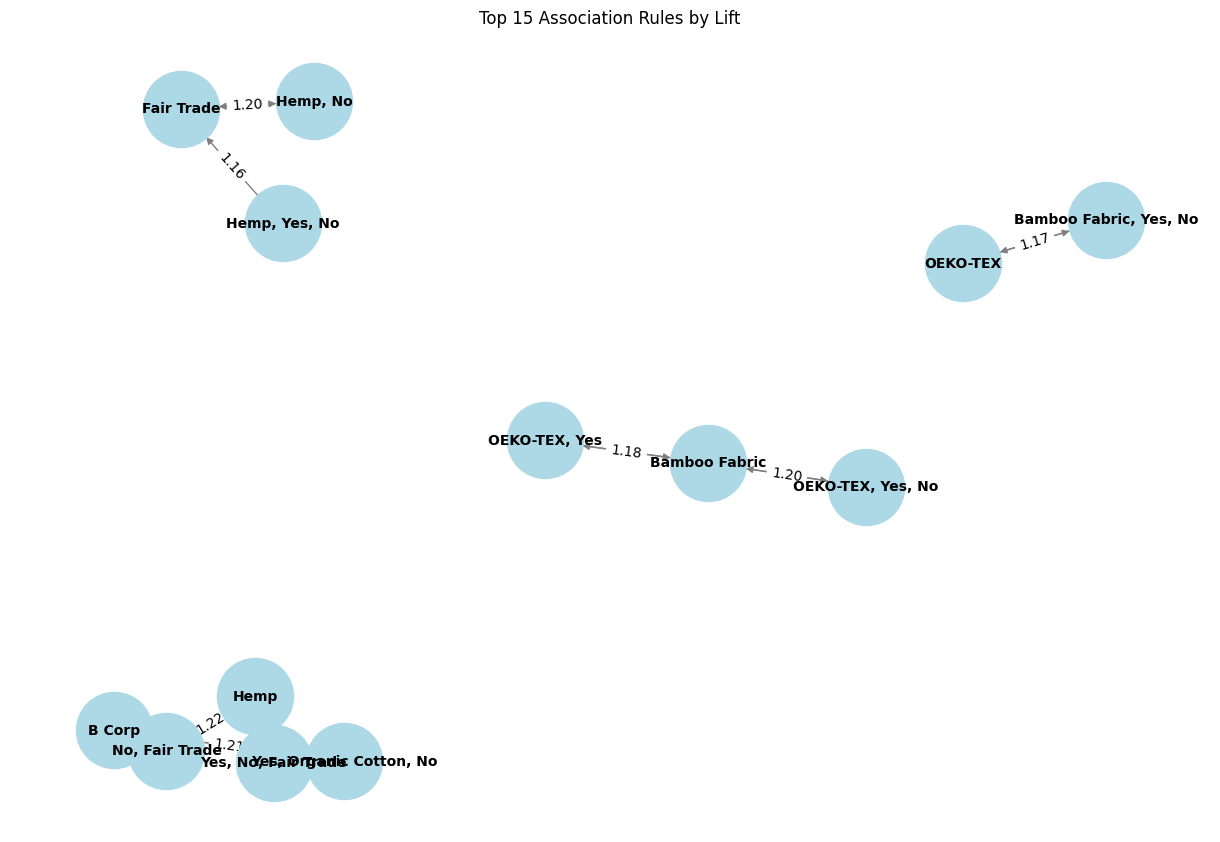

In [39]:
# Generate visualization for top 15 rules by lift
draw_network_graph(top_lift, "Top 15 Association Rules by Lift")


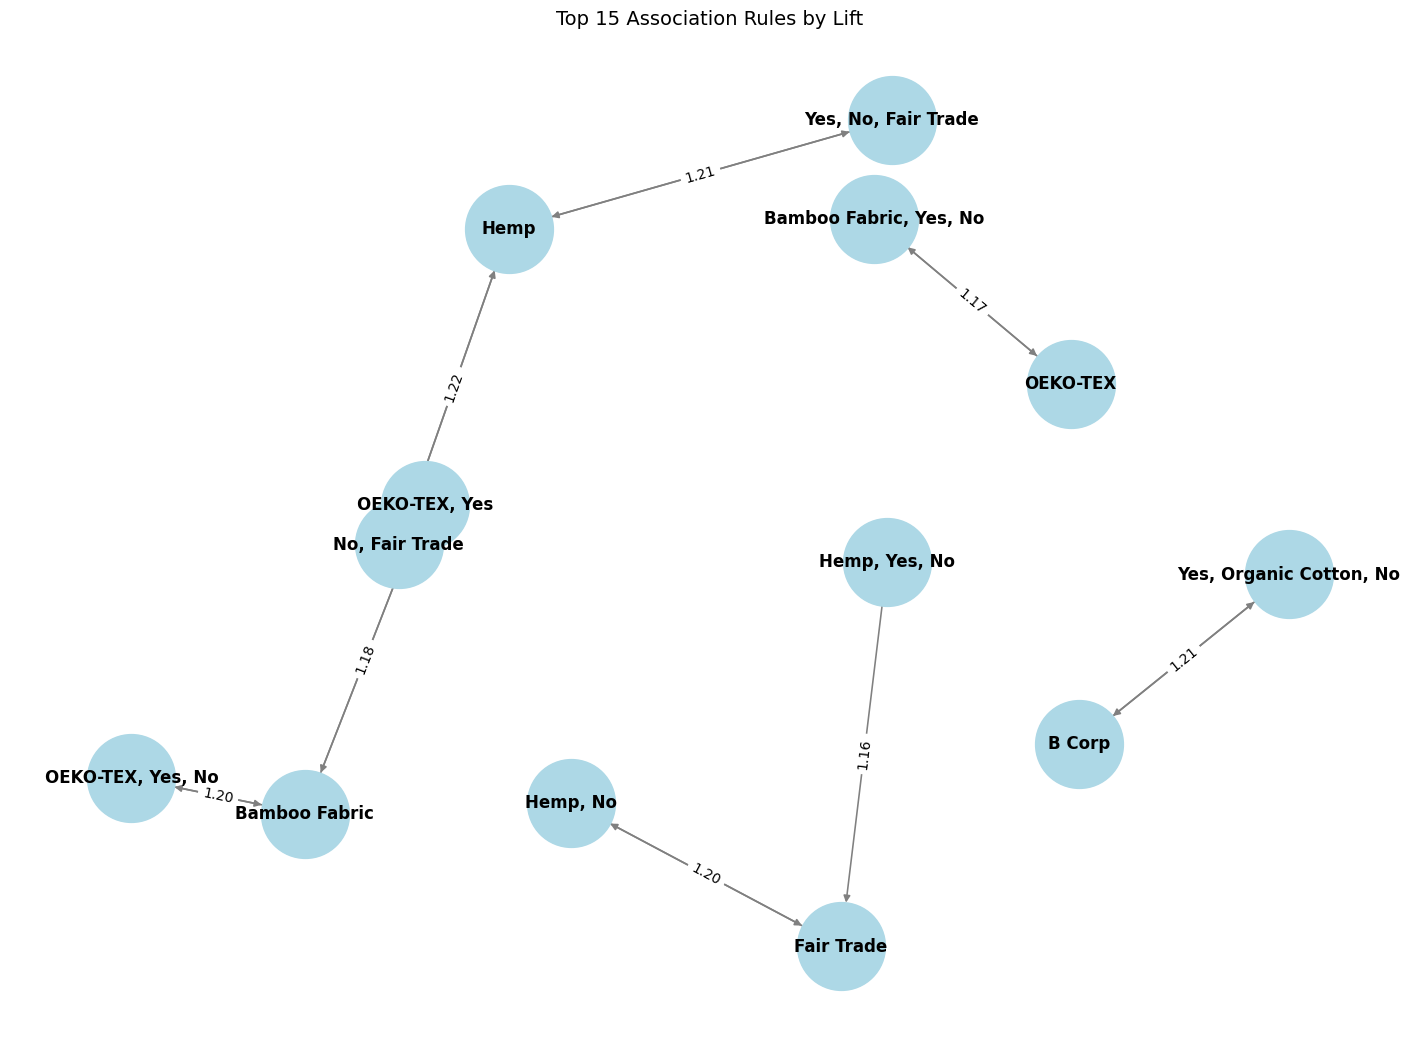

In [40]:
# Enhanced Visualization - Network Graph of Association Rules
def draw_network_graph(rules_df, title):
    G = nx.DiGraph()

    for _, row in rules_df.iterrows():
        antecedents = row['antecedents']
        consequents = row['consequents']
        weight = row['lift']
        G.add_edge(antecedents, consequents, weight=weight)

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1.2)  # Adjusted layout for better spacing

    # Draw nodes and edges with better visibility
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
            node_size=4000, font_size=12, font_weight='bold', width=[d['weight'] for (u,v,d) in G.edges(data=True)])

    # Draw edge labels with lift values
    labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

    plt.title(title, fontsize=14)
    plt.show()

# Generate visualization for top 15 rules by lift
draw_network_graph(top_lift, "Top 15 Association Rules by Lift")


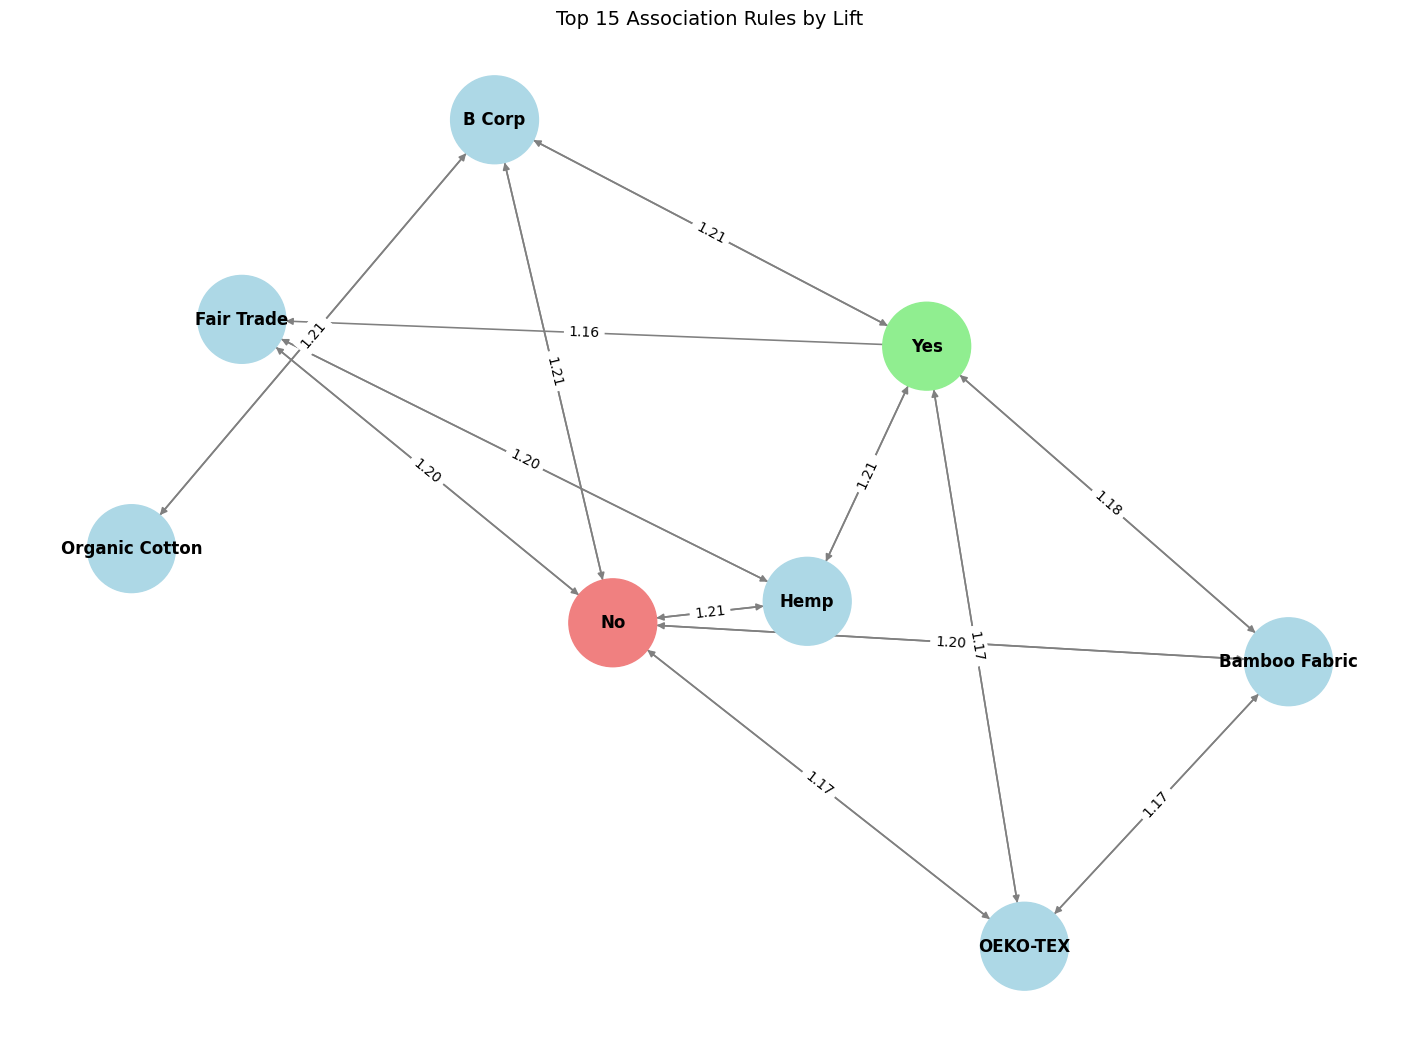

In [41]:
def draw_network_graph(rules_df, title):
    G = nx.DiGraph()

    for _, row in rules_df.iterrows():
        antecedents = row['antecedents'].split(', ')
        consequents = row['consequents'].split(', ')
        weight = row['lift']

        for ant in antecedents:
            for cons in consequents:
                G.add_edge(ant, cons, weight=weight)

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1.5)  # Adjusted layout for better spacing

    # Separate Yes/No values into different branches
    node_colors = []
    for node in G.nodes():
        if "Yes" in node:
            node_colors.append("lightgreen")
        elif "No" in node:
            node_colors.append("lightcoral")
        else:
            node_colors.append("lightblue")

    # Draw nodes and edges with better visibility
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray',
            node_size=4000, font_size=12, font_weight='bold', width=[d['weight'] for (u,v,d) in G.edges(data=True)])

    # Draw edge labels with lift values
    labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

    plt.title(title, fontsize=14)
    plt.show()

# Generate visualization for top 15 rules by lift
draw_network_graph(top_lift, "Top 15 Association Rules by Lift")


The association rule mining (ARM) network graph provides valuable insights into fashion sustainability trends by revealing relationships between eco-friendly materials, certifications, and sustainable practices. The visualization highlights a clear divide between brands that actively adopt sustainability ("Yes" cluster) and those that do not ("No" cluster). Notably, brands that commit to B Corp and Fair Trade certifications tend to incorporate organic and recycled materials such as Hemp, Bamboo Fabric, and Organic Cotton, indicating a strong correlation between ethical certifications and sustainable material choices. Additionally, the frequent co-occurrence of OEKO-TEX certification with Bamboo Fabric and Organic Cotton suggests that brands focused on chemical-free textiles also prioritize other sustainability measures. However, the relatively low lift values (1.17-1.22) indicate that while these relationships exist, they are not overwhelmingly deterministic. This finding underscores that while sustainable practices often appear together, there is still variability in how brands approach sustainability. The presence of a "No" cluster, where brands that do not follow one sustainability criterion tend to neglect others, suggests a polarization within the fashion industry, where some brands fully embrace eco-friendly practices while others do not. Overall, these insights reinforce the idea that sustainability in fashion is multifaceted, with certifications playing a crucial role in driving broader eco-conscious decisions.

In [51]:
def draw_network_graph(rules_df, title, metric):
    G = nx.DiGraph()

    for _, row in rules_df.iterrows():
        antecedents = row['antecedents'].split(', ')
        consequents = row['consequents'].split(', ')
        weight = row[metric]

        for ant in antecedents:
            for cons in consequents:
                G.add_edge(ant, cons, weight=weight)

    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=1.5)  # Adjusted layout for better spacing

    # Separate Yes/No values into different branches
    node_colors = []
    for node in G.nodes():
        if "Yes" in node:
            node_colors.append("lightgreen")
        elif "No" in node:
            node_colors.append("lightcoral")
        else:
            node_colors.append("lightblue")

    # Draw nodes and edges with better visibility
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray',
            node_size=4000, font_size=12, font_weight='bold', width=[d['weight'] for (u,v,d) in G.edges(data=True)])

    # Draw edge labels with selected metric values
    labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

    plt.title(title, fontsize=14)
    plt.show()


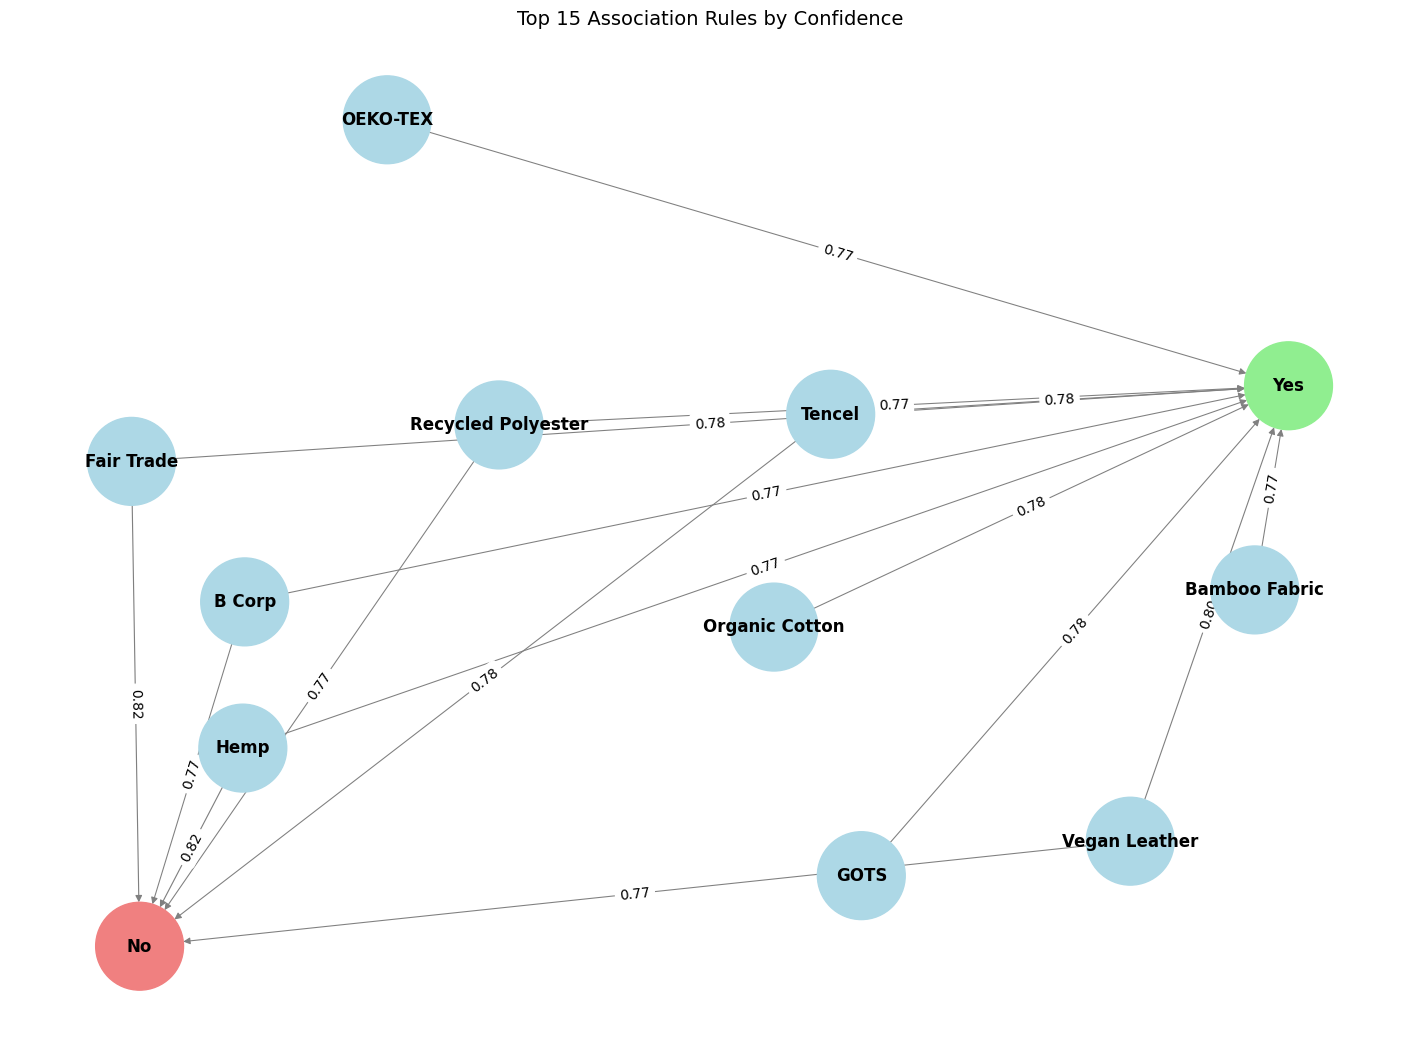

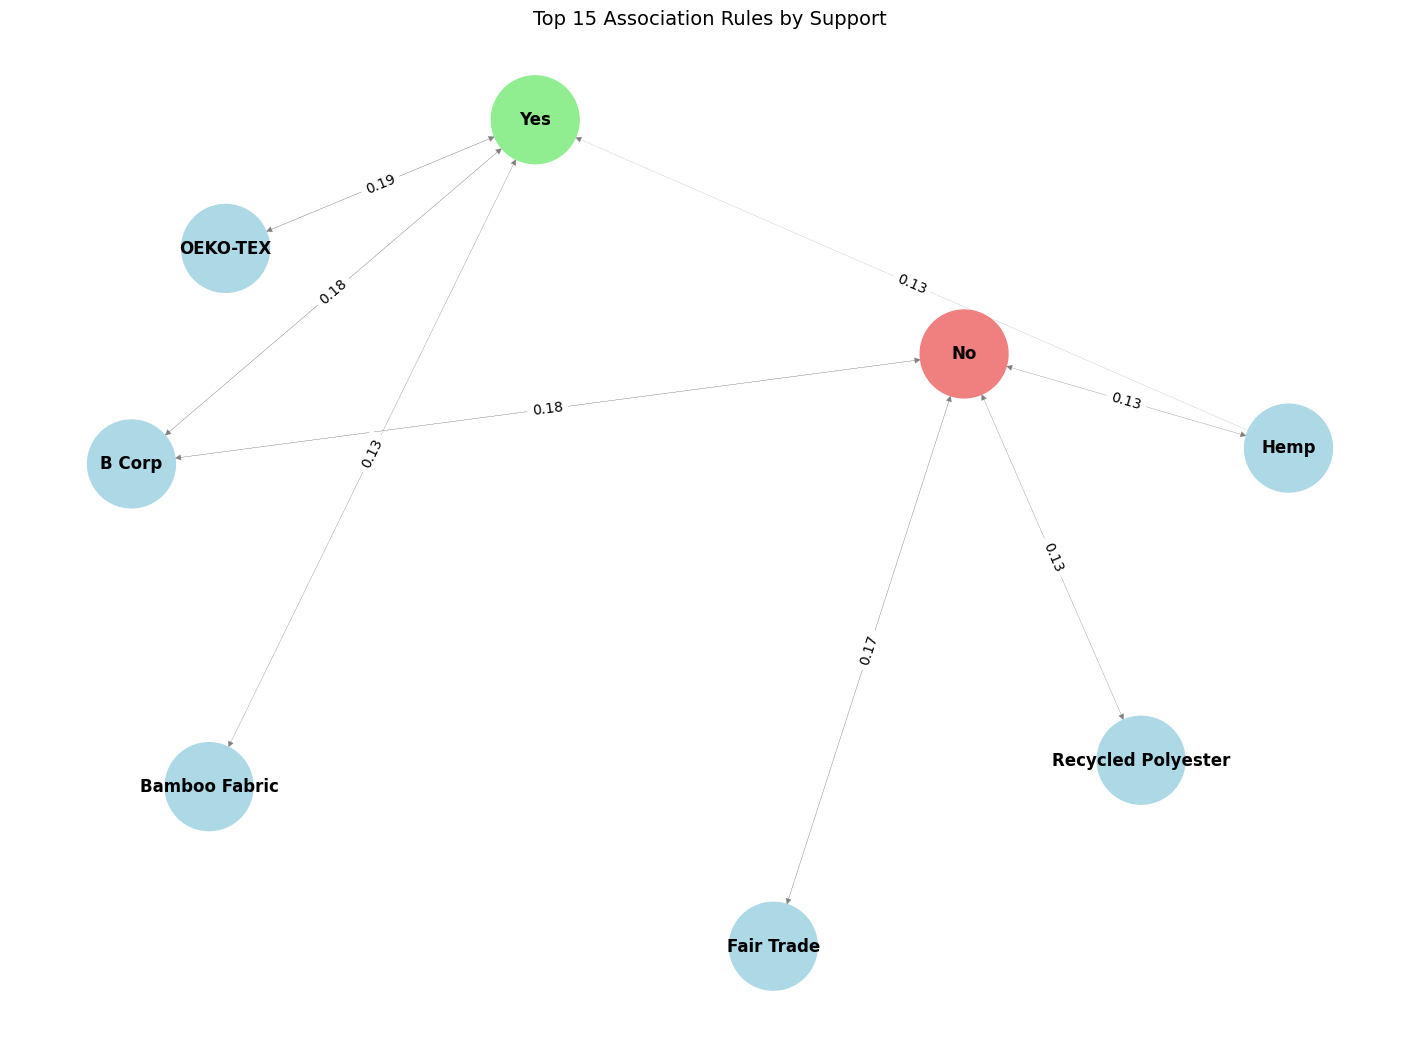

In [52]:
# Generate visualization for top 15 rules by Confidence
draw_network_graph(top_confidence, "Top 15 Association Rules by Confidence", "confidence")

# Generate visualization for top 15 rules by Support
draw_network_graph(top_support, "Top 15 Association Rules by Support", "support")


In [43]:
import seaborn as sns

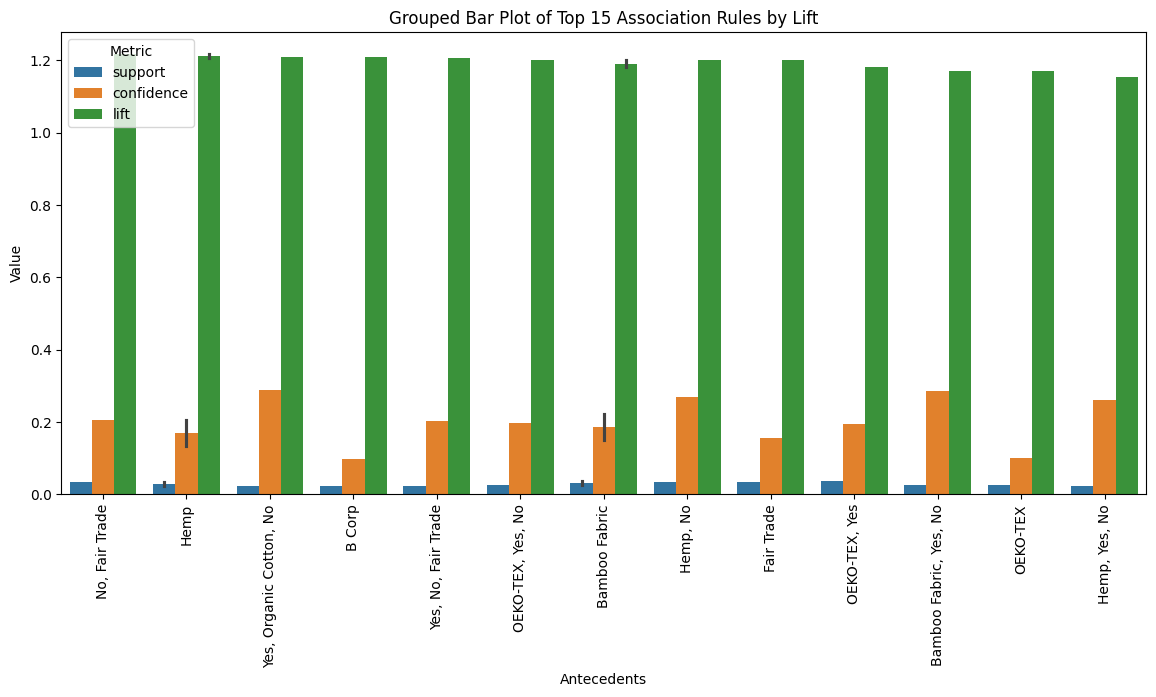

In [44]:
# Grouped Bar Plot for Association Rules
def plot_grouped_bar(rules_df, title):
    plt.figure(figsize=(14, 6))

    melted_rules = rules_df.melt(id_vars=["antecedents", "consequents"],
                                 value_vars=["support", "confidence", "lift"],
                                 var_name="Metric", value_name="Value")

    sns.barplot(data=melted_rules, x="antecedents", y="Value", hue="Metric")
    plt.xticks(rotation=90)
    plt.xlabel("Antecedents")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend(title="Metric")
    plt.show()

# Plot grouped bar chart for top rules
plot_grouped_bar(top_lift, "Grouped Bar Plot of Top 15 Association Rules by Lift")


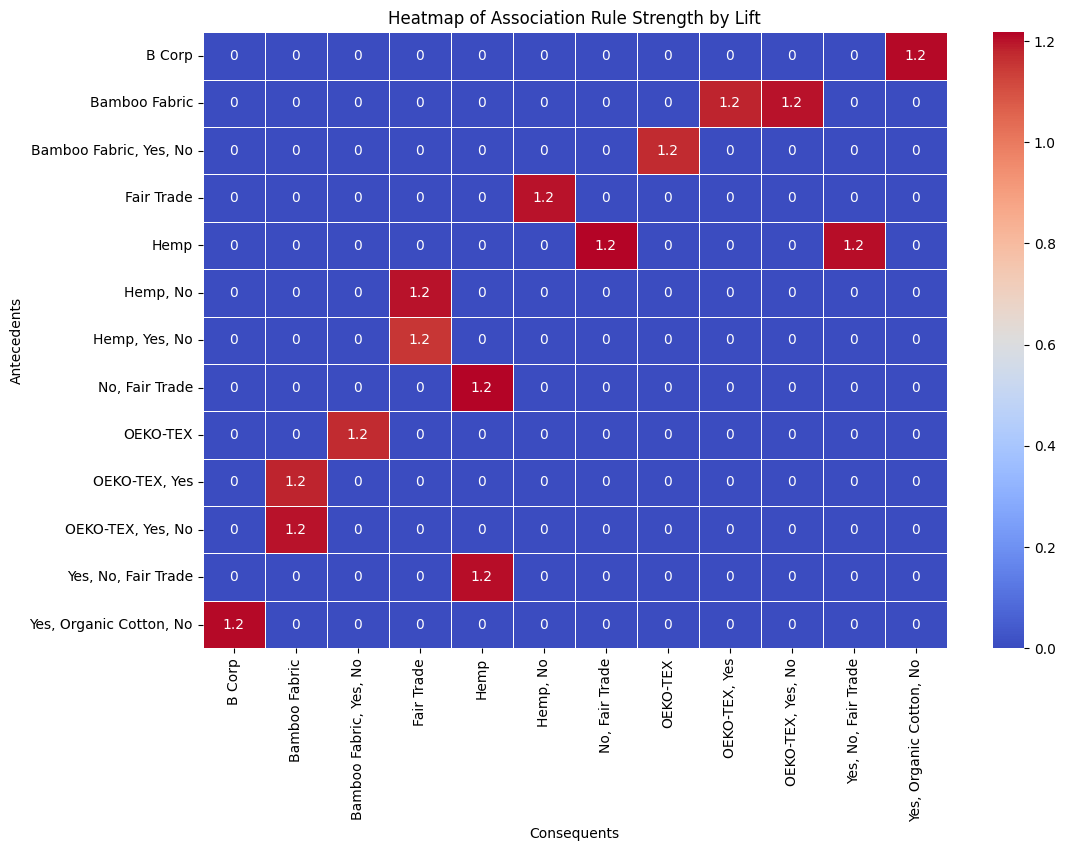

In [45]:
# Heatmap for rule strength
def plot_heatmap(rules_df, title):
    pivot_table = rules_df.pivot(index="antecedents", columns="consequents", values="lift").fillna(0)

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.xlabel("Consequents")
    plt.ylabel("Antecedents")
    plt.title(title)
    plt.show()

# Generate heatmap for rule strength
plot_heatmap(top_lift, "Heatmap of Association Rule Strength by Lift")

### **Insights from the Heatmap of Association Rule Strength by Lift**

The heatmap provides a clear visual representation of **how strongly different sustainability-related attributes in the fashion industry are associated with each other**. The values in the heatmap represent **lift scores**, where a lift greater than 1 indicates a **stronger-than-random association** between two attributes.

#### **Key Observations:**
1. **B Corp and Organic Cotton ("Yes") Have the Strongest Association (Lift = 1.2)**  
   - This suggests that brands with **B Corp certification** are highly likely to adopt **organic cotton** as part of their sustainability strategy.
   - The presence of this link reinforces the idea that **certified ethical brands prioritize sustainable materials**.

2. **OEKO-TEX Certification and Bamboo Fabric Show a Strong Connection (Lift = 1.2)**  
   - OEKO-TEX certification ensures that textiles are **free from harmful substances**, making its association with **Bamboo Fabric** significant.
   - This means that brands using **Bamboo Fabric** often go a step further in ensuring it meets strict chemical safety standards.

3. **Fair Trade is Strongly Linked to Multiple Sustainability Attributes (Lift = 1.2)**  
   - Fair Trade certification is closely associated with:
     - **No, Fair Trade** (indicating some brands explicitly choosing against Fair Trade principles)
     - **Hemp-related products** (suggesting that Fair Trade brands also favor eco-friendly materials)
   - This suggests that **Fair Trade brands tend to take a holistic approach to sustainability**, incorporating multiple ethical and environmental principles.

4. **Hemp ("No") and Hemp ("Yes, No") Appear in Significant Associations (Lift = 1.2)**  
   - The **split in Hemp-based associations** (one with "No" and one with "Yes, No") indicates that brands are divided on using hemp as a sustainable material.
   - Some brands adopt it fully, while others **hesitate** due to factors like cost or supply chain limitations.

5. **Bamboo Fabric (Yes, No) and OEKO-TEX (Yes, No) Show a Lift of 1.2**  
   - This suggests that **brands committed to certain eco-friendly certifications may selectively apply them** across different product lines.
   - It may indicate **inconsistency** where brands adopt **Bamboo Fabric but not always under OEKO-TEX certification**.

#### **General Takeaways**
- **Sustainability certifications play a key role** in influencing material choices.
- **Lift values are generally close to 1.2**, meaning **moderate but meaningful correlations** between sustainability attributes.
- **Some brands selectively apply sustainability practices**, leading to variations in certification and material adoption.
- The **relationship between eco-friendly materials and certifications** indicates that brands focusing on **chemical safety (OEKO-TEX)** or **worker welfare (Fair Trade, B Corp)** also prioritize sustainable materials like **Organic Cotton and Bamboo Fabric**.

This heatmap helps identify **where sustainability efforts are most concentrated** and where **inconsistencies exist**, guiding fashion brands and consumers towards **stronger, more integrated sustainability commitments**. 🚀